
# Global Sentiment and Emotion Analysis of COVID-19 Tweets

### Alessandro Bottardi

This notebook performs:
1. **Loading** datasets (`Corona_NLP_train.csv`, `Corona_NLP_test.csv`).
2. **Cleaning** data
3. **EDA**: class distribution, tweet length, (optional) wordcloud.
4. **Emotion Classification** with a pretrained transformer (e.g., joy, fear, sadness, anger, neutral).
5. **Fine-tuning BERT** using labeled sentiment (from *extremely negative* to *extremely positive*).
6. **Confusion Matrix** on the test set.
7. **World Map with Folium**: state-level markers based on the `Location` field.


In [ ]:

!pip install pandas matplotlib wordcloud transformers datasets torch scikit-learn folium --quiet

import os, re, math, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, classification_report
import glob, shutil
from pathlib import Path
import unicodedata
import webbrowser
import torch.nn.functional as F
from IPython.display import IFrame
from urllib.parse import urlparse
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding,
    __version__ as trfs_version
)

# Optional imports for environments without internet/access
try:
    from wordcloud import WordCloud
except Exception as e:
    WordCloud = None
    print("WordCloud not available:", e)

try:
    import folium
except Exception as e:
    folium = None
    print("Folium not available:", e)

# Transformers
try:
    from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
    TRANSFORMERS_OK = True
except Exception as e:
    TRANSFORMERS_OK = False
    print("Transformers not available:", e)

# Datasets + metrics
try:
    from datasets import Dataset
    DATASETS_OK = True
except Exception as e:
    DATASETS_OK = False
    print("datasets (HF) not available:", e)

try:
    from sklearn.metrics import classification_report, confusion_matrix
    SKLEARN_OK = True
except Exception as e:
    SKLEARN_OK = False
    print("sklearn not available:", e)

# Plotting
plt.rcParams["figure.figsize"] = (8, 5)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## 1) Load data

In [ ]:

# Adjust paths if needed
TRAIN_PATH = Path.cwd() / "data/Corona_NLP_train.csv"
TEST_PATH  = Path.cwd() / "data/Corona_NLP_test.csv"

# Try multiple encodings just in case
def read_csv_flexible(path):
    for enc in ("utf-8", "latin-1", "utf-16", "cp1252"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    # Fallback
    return pd.read_csv(path, encoding="latin-1", on_bad_lines="skip")

train_df = read_csv_flexible(TRAIN_PATH)
test_df  = read_csv_flexible(TEST_PATH)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
display(train_df.head(3))
display(test_df.head(3))


Train shape: (41157, 6)
Test shape: (3798, 6)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive


## 2) Data cleaning

In [28]:

TEXT_COL_CANDIDATES = ["OriginalTweet", "text", "TweetText", "Clean_Tweet"]
LABEL_COL_CANDIDATES = ["Sentiment", "sentiment", "label"]
LOCATION_COL_CANDIDATES = ["Location", "location", "UserLocation"]

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    # If nothing found, fallback to first column
    return candidates[0]

TEXT_COL = pick_col(train_df, TEXT_COL_CANDIDATES)
LABEL_COL = pick_col(train_df, LABEL_COL_CANDIDATES)
LOCATION_COL = pick_col(train_df, LOCATION_COL_CANDIDATES)

print("Using columns -> TEXT:", TEXT_COL, "| LABEL:", LABEL_COL, "| LOCATION:", LOCATION_COL if LOCATION_COL in train_df.columns else "N/A")

URL_RE = re.compile(r"http\S+|www\.\S+")
NONALPHA_RE = re.compile(r"[^a-zA-Z\s]")

def clean_text(s):
    s = str(s)
    s = s.lower()
    s = URL_RE.sub("", s)
    s = NONALPHA_RE.sub(" ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

train_df["clean_text"] = train_df[TEXT_COL].apply(clean_text)
test_df["clean_text"]  = test_df[TEXT_COL].apply(clean_text)

train_df["n_tokens"] = train_df["clean_text"].str.split().apply(len)
test_df["n_tokens"]  = test_df["clean_text"].str.split().apply(len)

print("Avg tokens (train):", train_df["n_tokens"].mean())
print("Avg tokens (test):", test_df["n_tokens"].mean())


Using columns -> TEXT: OriginalTweet | LABEL: Sentiment | LOCATION: Location
Avg tokens (train): 29.87924289914231
Avg tokens (test): 32.69457609268036


## 3) Exploratory Data Analysis (EDA)

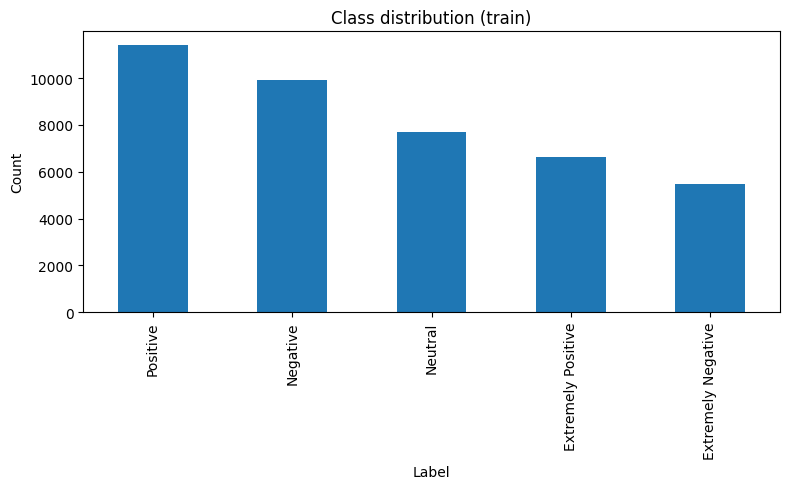

In [51]:
# Class distribution
label_counts = train_df[LABEL_COL].value_counts()
plt.figure()
label_counts.plot(kind="bar")
plt.title("Class distribution (train)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



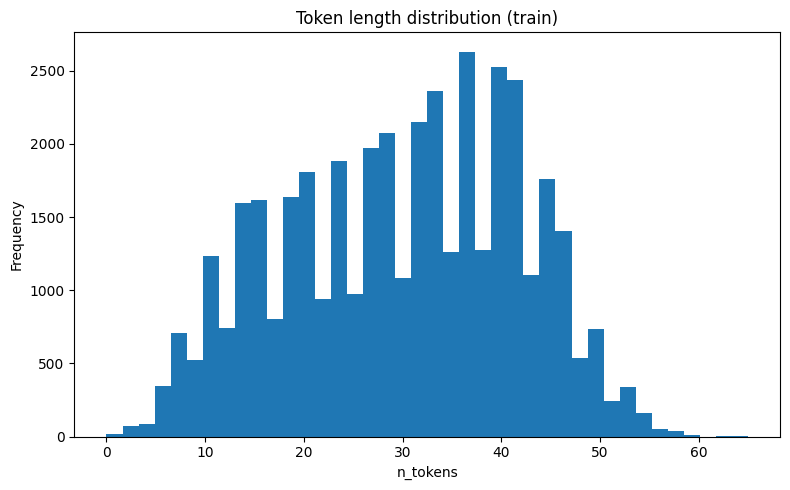

In [52]:
# Token length histogram
plt.figure()
train_df["n_tokens"].plot(kind="hist", bins=40)
plt.title("Token length distribution (train)")
plt.xlabel("n_tokens")
plt.tight_layout()
plt.show()

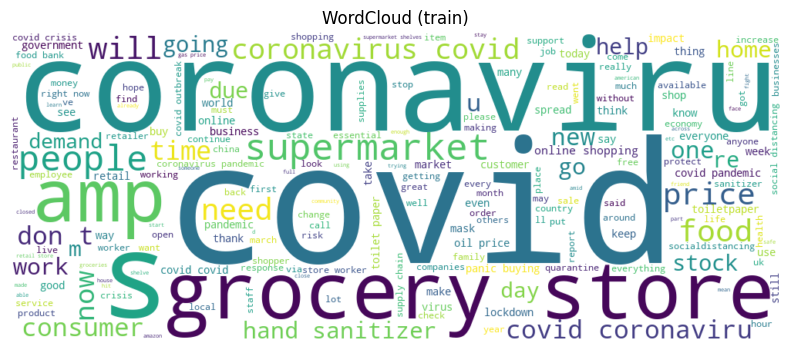

In [53]:
# Wordcloud on train
if WordCloud is not None:
    text_all = " ".join(train_df["clean_text"].dropna().tolist())
    wc = WordCloud(width=1000, height=400, background_color="white").generate(text_all)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("WordCloud (train)")
    plt.show()
else:
    print("Skipping WordCloud (package not available).")

In [ ]:
try:
    from sklearn.feature_extraction.text import CountVectorizer
    SKLEARN_OK = True
except Exception:
    SKLEARN_OK = False
    print("[Info] scikit-learn not available; skipping n-gram analysis.")

In [55]:

ARTIFACTS_DIR = Path.cwd() / "artifacts"
ARTIFACTS_DIR.mkdir(exist_ok=True)

# Resolve TEXT_COL and LABEL_COL if not defined
if 'TEXT_COL' not in globals():
    TEXT_COL = 'clean_text' if 'clean_text' in train_df.columns else None
    if TEXT_COL is None:
        for c in ['OriginalTweet','text','TweetText']:
            if c in train_df.columns:
                TEXT_COL = c
                break
    if TEXT_COL is None:
        raise ValueError("Cannot find a text column. Create 'clean_text' or set TEXT_COL manually.")

if 'LABEL_COL' not in globals():
    for c in ['Sentiment','label','Label','labels','target','Target']:
        if c in train_df.columns:
            LABEL_COL = c
            break
    if 'LABEL_COL' not in globals():
        raise ValueError("Cannot find a label column. Set LABEL_COL to your target name.")

# Join train/test just for descriptive EDA; keep a 'split' column
train_tmp = train_df.copy()
train_tmp['split'] = 'train'
test_tmp  = test_df.copy()
test_tmp['split']  = 'test'
eda_df = pd.concat([train_tmp, test_tmp], axis=0, ignore_index=True)



In [56]:
# Missingness and duplicates
def missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().mean().sort_values(ascending=False)
    out = pd.DataFrame({'missing_ratio': miss, 'n_missing': (df.isna().sum())})
    out['n_rows'] = len(df)
    out['dtype'] = df.dtypes.astype(str)
    return out

miss_train = missing_summary(train_df)
miss_test  = missing_summary(test_df)
miss_train.to_csv(ARTIFACTS_DIR / "missing_train.csv")
miss_test.to_csv(ARTIFACTS_DIR / "missing_test.csv")

dup_train = train_df.duplicated(subset=[TEXT_COL]).sum()
dup_test  = test_df.duplicated(subset=[TEXT_COL]).sum()
print(f"[Missing] train -> saved to artifacts/missing_train.csv  |  duplicates (by {TEXT_COL}): {dup_train}")
print(f"[Missing] test  -> saved to artifacts/missing_test.csv   |  duplicates (by {TEXT_COL}): {dup_test}")



[Missing] train -> saved to artifacts/missing_train.csv  |  duplicates (by clean_text): 174
[Missing] test  -> saved to artifacts/missing_test.csv   |  duplicates (by clean_text): 6


In [ ]:

# N-grams (overall + per class)
def top_ngrams(texts, ngram_range=(1,1), top_k=25, stop_words='english', min_df=2):
    if not SKLEARN_OK:
        return pd.DataFrame(columns=['ngram','count'])
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words, lowercase=True,
                          token_pattern=r"(?u)\b\w\w+\b", min_df=min_df)
    X = vec.fit_transform(texts)
    counts = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    order = counts.argsort()[::-1][:top_k]
    return pd.DataFrame({'ngram': vocab[order], 'count': counts[order]})

# Overall (train only, to avoid leakage if needed)
uni_overall = top_ngrams(train_df[TEXT_COL].astype(str).tolist(), (1,1), 30)
bi_overall  = top_ngrams(train_df[TEXT_COL].astype(str).tolist(), (2,2), 30)

uni_overall.to_csv(ARTIFACTS_DIR / "top_unigrams_overall.csv", index=False)
bi_overall.to_csv(ARTIFACTS_DIR / "top_bigrams_overall.csv", index=False)

# Per class (train)
per_class_uni = {}
per_class_bi  = {}
for lab, sub in train_df.groupby(LABEL_COL):
    txts = sub[TEXT_COL].dropna().astype(str).tolist()
    per_class_uni[lab] = top_ngrams(txts, (1,1), 20)
    per_class_bi[lab]  = top_ngrams(txts, (2,2), 20)
    per_class_uni[lab].to_csv(ARTIFACTS_DIR / f"top_unigrams_{str(lab).replace(' ','_')}.csv", index=False)
    per_class_bi[lab].to_csv(ARTIFACTS_DIR / f"top_bigrams_{str(lab).replace(' ','_')}.csv", index=False)
print("[EDA] Saved n-gram CSVs (overall + per class) in ./artifacts/")



[EDA] Saved n-gram CSVs (overall + per class) in ./artifacts/


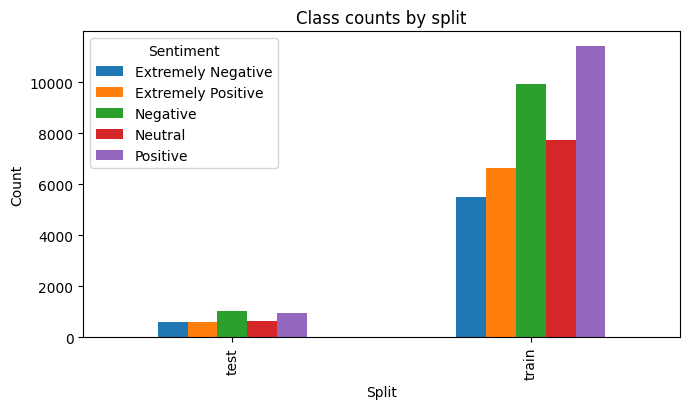

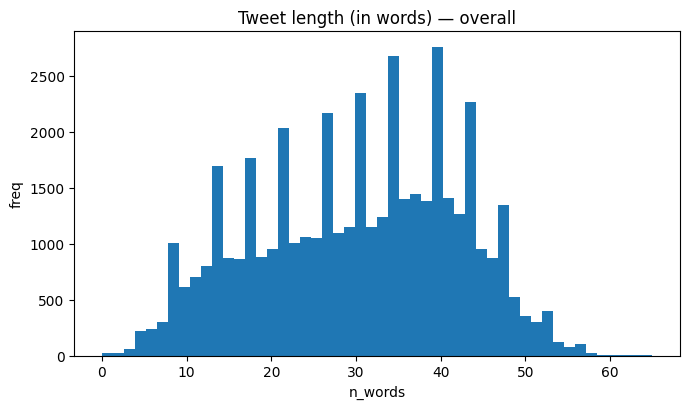

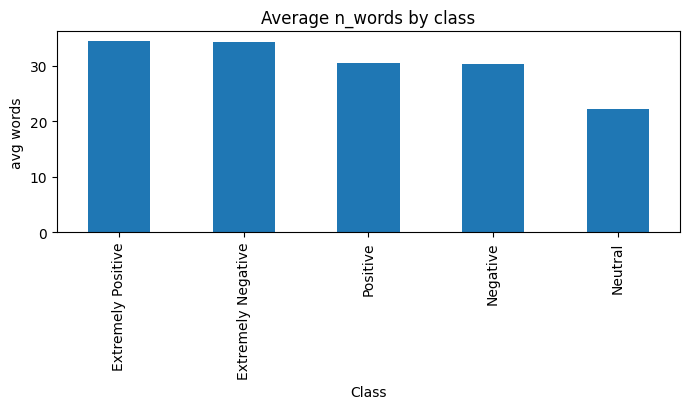

In [61]:
# Plots
plt.rcParams['figure.figsize'] = (7.0, 4.2)

# Class balance (train vs test)
fig1, ax1 = plt.subplots()
(eda_df.groupby(['split', LABEL_COL]).size().unstack(fill_value=0)
      .plot(kind='bar', ax=ax1))
ax1.set_title('Class counts by split')
ax1.set_xlabel('Split')
ax1.set_ylabel('Count')
plt.tight_layout()
fig1_path = ARTIFACTS_DIR / "plot_class_counts_by_split.png"
fig1.savefig(fig1_path, dpi=140)
plt.show()

# Length distribution (words)
fig2, ax2 = plt.subplots()
eda_df['n_words'].plot(kind='hist', bins=50, ax=ax2)
ax2.set_title('Tweet length (in words) — overall')
ax2.set_xlabel('n_words'); ax2.set_ylabel('freq')
plt.tight_layout()
fig2_path = ARTIFACTS_DIR / "plot_length_hist_overall.png"
fig2.savefig(fig2_path, dpi=140)
plt.show()

# Average length by class (bars)
fig3, ax3 = plt.subplots()
eda_df.groupby(LABEL_COL)['n_words'].mean().sort_values(ascending=False).plot(kind='bar', ax=ax3)
ax3.set_title('Average n_words by class')
ax3.set_xlabel('Class'); ax3.set_ylabel('avg words')
plt.tight_layout()
fig3_path = ARTIFACTS_DIR / "plot_avg_words_by_class.png"
fig3.savefig(fig3_path, dpi=140)
plt.show()
    


[EDA] Saved timeline CSV to /Users/alessandrobottardi/Desktop/progetto_individuale/artifacts/timeline_by_class.csv


/var/folders/nr/cvsjhvxj1vb6mmg7djn1dr6r0000gn/T/ipykernel_17306/3808156124.py:10: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  eda_df['_date'] = pd.to_datetime(eda_df[date_col], errors='coerce').dt.date


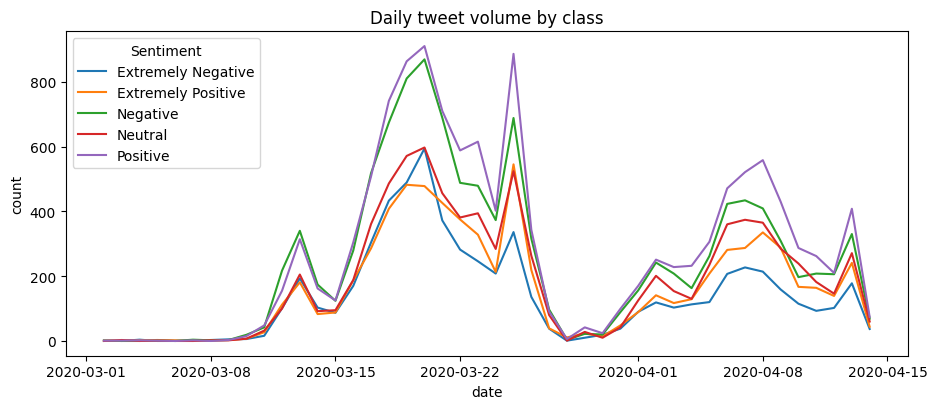

In [ ]:
# Timeline by date
date_col = None
for c in ['TweetAt','date','Date','created_at','CreatedAt']:
    if c in eda_df.columns:
        date_col = c
        break

if date_col is not None:
    # Parse to date
    eda_df['_date'] = pd.to_datetime(eda_df[date_col], errors='coerce').dt.date
    timeline = (eda_df.dropna(subset=['_date'])
                      .groupby(['_date', LABEL_COL]).size()
                      .unstack(fill_value=0)
                      .sort_index())

    # Save CSV
    timeline.to_csv(ARTIFACTS_DIR / "timeline_by_class.csv")
    print(f"[EDA] Saved timeline CSV to {ARTIFACTS_DIR / 'timeline_by_class.csv'}")

    # Plot
    fig5, ax5 = plt.subplots(figsize=(9.5, 4.2))
    timeline.plot(ax=ax5)
    ax5.set_title('Daily tweet volume by class')
    ax5.set_xlabel('date'); ax5.set_ylabel('count')
    plt.tight_layout()
    fig5_path = ARTIFACTS_DIR / "plot_timeline_by_class.png"
    fig5.savefig(fig5_path, dpi=150)
    plt.show()
else:
    print("[EDA] No date-like column found (e.g., TweetAt). Skipping timeline plot.")
    


In [66]:
# Quick recap tables
print("\n[Peek] Per-class descriptive means:")
print(per_class_stats.round(3))

print("\n[Saved]")
for p in [fig1_path, fig2_path, fig3_path]:
    print(" -", p)
if date_col is not None:
    print(" -", fig5_path)

print(" -", ARTIFACTS_DIR / "top_unigrams_overall.csv")
print(" -", ARTIFACTS_DIR / "top_bigrams_overall.csv")



[Peek] Per-class descriptive means:
                    n_chars  n_words  excl  quest  caps_ratio  has_url  \
Sentiment                                                                
Extremely Positive  202.781   34.525   0.0    0.0         0.0      0.0   
Extremely Negative  199.396   34.376   0.0    0.0         0.0      0.0   
Positive            181.117   30.496   0.0    0.0         0.0      0.0   
Negative            179.303   30.355   0.0    0.0         0.0      0.0   
Neutral             138.846   22.317   0.0    0.0         0.0      0.0   

                    has_mention  has_hashtag  has_emoji  
Sentiment                                                
Extremely Positive          0.0          0.0        0.0  
Extremely Negative          0.0          0.0        0.0  
Positive                    0.0          0.0        0.0  
Negative                    0.0          0.0        0.0  
Neutral                     0.0          0.0        0.0  

[Saved]
 - /Users/alessandrobottardi/


## 4) Pretrained BERT for Emotion Classification

We will use a pretrained transformer specialized in emotions:
- `j-hartmann/emotion-english-distilroberta-base` (labels include anger, disgust, fear, joy, neutral, sadness, surprise).

> **Note**: Internet is required to download the model the first time, distilroBERTa was used in order to create a more lightweight model, so that it would be easier to train on a normal laptop.


In [30]:
EMOTION_MODEL = "j-hartmann/emotion-english-distilroberta-base"

if TRANSFORMERS_OK:
    try:
        emotion_clf = pipeline("text-classification", model=EMOTION_MODEL, tokenizer=EMOTION_MODEL, top_k=None, truncation=True)
        # Demo on a small sample
        sample_texts = train_df["clean_text"].dropna().head(5).tolist()
        emo_preds = [emotion_clf(t)[0] for t in sample_texts]
        for t, p in zip(sample_texts, emo_preds):
            print("\nText:", t[:120], "...")
            print("Pred:", p)
    except Exception as e:
        print("Emotion model not available or no internet:", e)
else:
    print("Transformers not available in this environment. Skipping.")


Device set to use mps:0



Text: menyrbie phil gahan chrisitv and and ...
Pred: [{'label': 'neutral', 'score': 0.48110431432724}, {'label': 'joy', 'score': 0.3063332736492157}, {'label': 'surprise', 'score': 0.14949633181095123}, {'label': 'sadness', 'score': 0.04931513965129852}, {'label': 'anger', 'score': 0.008133510127663612}, {'label': 'fear', 'score': 0.003445264184847474}, {'label': 'disgust', 'score': 0.0021722109522670507}]

Text: advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours sch ...
Pred: [{'label': 'neutral', 'score': 0.6816755533218384}, {'label': 'sadness', 'score': 0.16886554658412933}, {'label': 'surprise', 'score': 0.06876610964536667}, {'label': 'anger', 'score': 0.030970154330134392}, {'label': 'fear', 'score': 0.02363990806043148}, {'label': 'joy', 'score': 0.02362760156393051}, {'label': 'disgust', 'score': 0.002455169567838311}]

Text: coronavirus australia woolworths to give elderly disabled dedicated shopping hours ami

DistilBERTa worked well on a sample of our dataset, we will then use it to have a more diversified classification of emotions when looking at a global perspective.


## 5) Fine-tuning distilBERT on labeled data

We will fine-tune `distilbert-base-uncased` on the 5 sentiment classes that our data was labeled with (e.g., *Extremely Negative* → *Extremely Positive*).
As in the previous section, we will train distilBERT as it provides us with an lighter model to work with.

- **Tip**: If the computational power of the laptop is higher/ the notebook is run on a computer which has access to a VM or GPUs, the number of epochs should be increased.
- Set `RUN_TRAINING = True` to actually train.


In [ ]:
RUN_TRAINING = False  # set to True to train

# Device pick (MPS on Mac; otherwise CUDA; otherwise CPU)
os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")

def pick_device():
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return "mps"
    if torch.cuda.is_available():
        return "cuda"
    return "cpu"

device = pick_device()
print("Using device:", device)

def empty_cache():
    try:
        if device == "cuda":
            torch.cuda.empty_cache()
        elif device == "mps":
            torch.mps.empty_cache()
    except Exception:
        pass

empty_cache()

# Artifacts and cache directories
BASE_DIR = Path.cwd()
ARTIFACTS_DIR = BASE_DIR / "artifacts"
HF_CACHE_DIR  = BASE_DIR / ".hf_cache"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
HF_CACHE_DIR.mkdir(parents=True, exist_ok=True)

os.environ["HF_HOME"] = str(HF_CACHE_DIR)
os.environ["TRANSFORMERS_CACHE"] = str(HF_CACHE_DIR)
os.environ["HUGGINGFACE_HUB_CACHE"] = str(HF_CACHE_DIR)

try:
    from datasets import Dataset
    DATASETS_OK = True
except Exception as e:
    DATASETS_OK = False
    print("datasets (HF) non disponibile:", e)

# Label mapping
unique_labels = sorted(train_df[LABEL_COL].dropna().unique().tolist())
label2id = {lab: i for i, lab in enumerate(unique_labels)}
id2label = {i: lab for lab, i in label2id.items()}
print("Label map:", label2id)

# Prepare datasets
train_df_model = (
    train_df[["clean_text", LABEL_COL]]
    .dropna()
    .rename(columns={LABEL_COL: "labels"})
)
test_df_model = (
    test_df[["clean_text", LABEL_COL]]
    .dropna()
    .rename(columns={LABEL_COL: "labels"})
)
train_df_model["labels"] = train_df_model["labels"].map(label2id).astype(int)
test_df_model["labels"]  = test_df_model["labels"].map(label2id).astype(int)

hf_train = Dataset.from_pandas(train_df_model, preserve_index=False)
hf_test  = Dataset.from_pandas(test_df_model,  preserve_index=False)

# distilBERT model
model_name = "distilbert-base-uncased" 

def clean_model_cache():
    pat = "models--" + model_name.replace("/", "--")
    for p in glob.glob(str(HF_CACHE_DIR / f"{pat}*")):
        shutil.rmtree(p, ignore_errors=True)

def load_tok_model():
    try:
        tok = AutoTokenizer.from_pretrained(model_name, use_fast=True, cache_dir=str(HF_CACHE_DIR))
        mdl = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=len(label2id),
            use_safetensors=True,
            cache_dir=str(HF_CACHE_DIR),
        )
        return tok, mdl
    except Exception as e:
        print("Failed loading, cleaning cache and retrying...\n", e)
        clean_model_cache()
        tok = AutoTokenizer.from_pretrained(model_name, use_fast=True, cache_dir=str(HF_CACHE_DIR))
        mdl = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=len(label2id),
            use_safetensors=True,
            cache_dir=str(HF_CACHE_DIR),
        )
        return tok, mdl

tokenizer, model = load_tok_model()

def tok(batch):
    return tokenizer(batch["clean_text"], padding=True, truncation=True, max_length=96)

hf_train = hf_train.map(tok, batched=True)
hf_test  = hf_test.map(tok,  batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Set model to device
model.to(torch.device(device))

# Training Arguments:
args = TrainingArguments(
    output_dir=str(ARTIFACTS_DIR / "results"),
    learning_rate=2e-5,
    per_device_train_batch_size=8,     
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,     
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=50,
    fp16=False, bf16=False,
    no_cuda=False,                     
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=hf_train,
    eval_dataset=hf_test,
    tokenizer=tokenizer,
    data_collator=data_collator
)

if RUN_TRAINING:
    try:
        empty_cache()
        trainer.train()
    finally:
        empty_cache()
    try:
        print(trainer.evaluate())
    except Exception as e:
        print("Evaluate not available:", e)
else:
    print("Training skipped (RUN_TRAINING=False)")

Using device: mps
Label map: {'Extremely Negative': 0, 'Extremely Positive': 1, 'Negative': 2, 'Neutral': 3, 'Positive': 4}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/41157 [00:00<?, ? examples/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Map: 100%|██████████| 3798/3798 [00:00<00:00, 26418.69 examples/s]
/var/folders/nr/cvsjhvxj1vb6mmg7djn1dr6r0000gn/T/ipykernel_17306/3001990843.py:139: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_c

Step,Training Loss
50,1.577800
100,1.446900
150,1.281800
200,1.200000
250,1.135400
300,1.060700
350,1.038100
400,1.018500
450,0.983200
500,0.956700


/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.5032815337181091, 'eval_runtime': 30.9969, 'eval_samples_per_second': 122.528, 'eval_steps_per_second': 15.324, 'epoch': 2.0}


As it can be easily deduced, even 2 epochs take a long time to run on a normal laptop. Better equipment is needed to increase the n° of epochs

- **Note that**: I had some overheating problems with my laptop and the after training results are heavy in terms of MB. I was basically forced to choose a very low number of epochs in order to have a complete notebook.


## 6) Inference on Test Set & Confusion Matrix

After training (or loading a fine-tuned checkpoint), we predict on the test set and plot a confusion matrix.


In [40]:
# Checkpoint: if kernel was restarted, you need to run Part 5 or load a checkpoint
if "model" not in globals() or "tokenizer" not in globals():
    raise RuntimeError("Model/tokenizer were not found. Run Part 5 (or load a checkpoint) before this cell.")

In [44]:
CHECKPOINT_NUM = 5146  # <- change if you want a different checkpoint id

def resolve_checkpoint_path(checkpoint_num=CHECKPOINT_NUM):
    """
    Try typical training output locations, then fall back to a recursive search.
    Returns a Path to '.../checkpoint-<num>' containing a config.json.
    """
    candidates = [
        Path.cwd() / "artifacts" / "results" / f"checkpoint-{checkpoint_num}",
        Path.cwd() / "results" / f"checkpoint-{checkpoint_num}",
        Path.cwd() / f"checkpoint-{checkpoint_num}",
    ]
    for p in candidates:
        if p.exists() and (p / "config.json").exists():
            return p

    # Fallback: recursive search in common bases
    bases = [Path.cwd() / "artifacts" / "results", Path.cwd() / "results", Path.cwd()]
    for base in bases:
        if base.exists():
            for p in base.rglob(f"checkpoint-{checkpoint_num}"):
                if (p / "config.json").exists():
                    return p

    raise FileNotFoundError(
        f"Could not find checkpoint-{checkpoint_num}. "
        f"Tried: {', '.join(str(c) for c in candidates)} and recursive search in artifacts/results, results, and cwd."
    )

ckpt_path = resolve_checkpoint_path()
print(f"[OK] Resolved checkpoint path: {ckpt_path}")

# Load from checkpoint directory
tokenizer = AutoTokenizer.from_pretrained(str(ckpt_path))
model = AutoModelForSequenceClassification.from_pretrained(str(ckpt_path))

# Pick best device (Apple MPS > CUDA > CPU)
def pick_device():
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return "mps"
    if torch.cuda.is_available():
        return "cuda"
    return "cpu"

device = pick_device()
model.to(torch.device(device)).eval()
print(f"[OK] Model loaded on device: {device}")

# Label mapping
unique_labels = sorted(train_df[LABEL_COL].dropna().unique().tolist())
label2id = {lab: i for i, lab in enumerate(unique_labels)}
id2label = {i: lab for lab, i in label2id.items()}
print("Label map:", label2id)


[OK] Resolved checkpoint path: /Users/alessandrobottardi/Desktop/progetto_individuale/artifacts/results/checkpoint-5146
[OK] Model loaded on device: mps
Label map: {'Extremely Negative': 0, 'Extremely Positive': 1, 'Negative': 2, 'Neutral': 3, 'Positive': 4}


Completed predictions: 3798 examples.


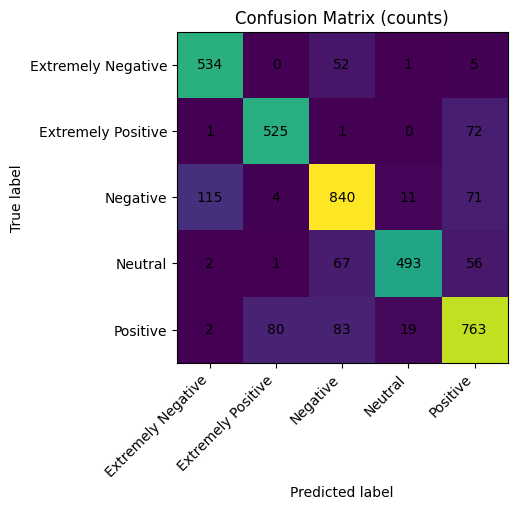

                    precision    recall  f1-score   support

Extremely Negative       0.82      0.90      0.86       592
Extremely Positive       0.86      0.88      0.87       599
          Negative       0.81      0.81      0.81      1041
           Neutral       0.94      0.80      0.86       619
          Positive       0.79      0.81      0.80       947

          accuracy                           0.83      3798
         macro avg       0.84      0.84      0.84      3798
      weighted avg       0.83      0.83      0.83      3798

Prediction CSV saved in: /Users/alessandrobottardi/Desktop/progetto_individuale/artifacts/test_predictions.csv
Confusion matrix figure saved in: /Users/alessandrobottardi/Desktop/progetto_individuale/artifacts/confusion_matrix.png


In [ ]:
def empty_cache():
    try:
        if device == "cuda":
            torch.cuda.empty_cache()
        elif device == "mps":
            torch.mps.empty_cache()
    except Exception:
        pass

empty_cache()


# Minimal reconstruction  if test_df_model is missing

# if "test_df_model" not in globals():
#     unique_labels = sorted(train_df[LABEL_COL].dropna().unique().tolist())
#     label2id = {lab: i for i, lab in enumerate(unique_labels)}
#     id2label = {i: lab for lab, i in label2id.items()}
#     test_df_model = (
#         test_df[["clean_text", LABEL_COL]]
#         .dropna()
#         .rename(columns={LABEL_COL: "labels"})
#     )
#     test_df_model["labels"] = test_df_model["labels"].map(label2id).astype(int)

# Inference parameters

MAX_LEN = 96
BATCH_SZ = 32 if device in ("cpu","mps") else 64 

model.eval()
model.to(torch.device(device))

y_true = test_df_model["labels"].tolist()
texts  = test_df_model["clean_text"].tolist()


y_pred = []
n = len(texts)

with torch.no_grad():
    for i in range(0, n, BATCH_SZ):
        batch_texts = texts[i:i+BATCH_SZ]
        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        logits = model(**enc).logits
        pred_ids = torch.argmax(logits, dim=1).cpu().numpy().tolist()
        y_pred.extend(pred_ids)

        empty_cache()

print(f"Completed predictions: {len(y_pred)} examples.")

# --- Confusion Matrix ---
labels_order = list(range(len(set(y_true))))  # 0..K-1
cm = confusion_matrix(y_true, y_pred, labels=labels_order)

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title('Confusion Matrix (counts)')

# Ticks e class names
if "id2label" in globals():
    class_names = [id2label[i] for i in labels_order]
else:
    # fallback: numerical names
    class_names = [str(i) for i in labels_order]

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)


for r in range(cm.shape[0]):
    for c in range(cm.shape[1]):
        ax.text(c, r, cm[r, c], ha='center', va='center', color='black')

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Save useful artifacts
import pandas as pd
preds_path = Path.cwd() / "artifacts/test_predictions.csv"
pd.DataFrame({"true": y_true, "pred": y_pred}).to_csv(preds_path, index=False)
print(f"Prediction CSV saved in: {preds_path}")

cm_png = Path.cwd() / "artifacts/confusion_matrix.png"
fig.savefig(cm_png, dpi=160, bbox_inches="tight")
print(f"Confusion matrix figure saved in: {cm_png}")

from pathlib import Path
ARTIFACTS_DIR = Path.cwd() / "artifacts"
ARTIFACTS_DIR.mkdir(exist_ok=True)
preds_path = ARTIFACTS_DIR / "test_predictions.csv"
cm_png     = ARTIFACTS_DIR / "confusion_matrix.png"


## 7) Folium Map of World tweets

We aggregate tweets by countries inferred from the `Location` field and plot state centroids as circle markers.


In [46]:
try:
    print("LOCATION_COL =", LOCATION_COL)
except NameError:
    LOCATION_COL = "Location"  # forza se non esiste
    print("LOCATION_COL non definita; imposto a", LOCATION_COL)

if LOCATION_COL not in train_df.columns:
    raise ValueError(f"La colonna '{LOCATION_COL}' non esiste nel dataframe.")

loc_nonnull = train_df[LOCATION_COL].dropna()
print("Valori Location non null:", len(loc_nonnull))
print("Esempi (20):")
print(loc_nonnull.sample(min(20, len(loc_nonnull)), random_state=42).to_list())
print("\nTop 30 Location:")
print(loc_nonnull.value_counts().head(30))

LOCATION_COL = Location
Valori Location non null: 32567
Esempi (20):
['Europe ', '22 // gender is a lie ', 'ORD ', 'Global', 'Niagara, Ontario', 'Los Angeles, CA', 'mumbai', 'San Francisco, CA', 'Southend, England', 'Chicago, IL', 'venus', 'North Bethesda, MD', 'Gurgaon, India', 'Bristol/ London', 'Exeter, UK', 'West of everything.', 'South San Francisco, CA', 'Whitley Bay, England', 'Australia', 'California, USA']

Top 30 Location:
Location
London                     540
United States              528
London, England            520
New York, NY               395
Washington, DC             373
United Kingdom             337
Los Angeles, CA            281
India                      268
UK                         232
Australia                  225
USA                        223
Canada                     191
England, United Kingdom    191
Toronto, Ontario           160
Global                     159
Chicago, IL                155
California, USA            153
San Francisco, CA          

### 7.1) Folium Map of World tweets with our own trained distilBERT

Folium will assign a color to each country based on the majority emotion between the tweets. (Dark green = Extremely Positive; Light green = Positive ... -> Dark red = Extremely Negative)

The map will show the predicted emotions map and the ground truth emotions map, so that comparisions will be easier to make


In [47]:
# Folium
try:
    import folium
except Exception as e:
    raise RuntimeError("Folium not available. Install with: %pip install folium") from e

ARTIFACTS_DIR = Path.cwd() / "artifacts"
ARTIFACTS_DIR.mkdir(exist_ok=True)
OUT_MAP = ARTIFACTS_DIR / "map_compare_world.html"

# Rebuild eval_df

if 'LOCATION_COL' not in globals():
    for c in ['Location','UserLocation','location','user_location','Place','place']:
        if c in test_df.columns:
            LOCATION_COL = c
            break
    else:
        raise ValueError("No Location column found in test_df.")


test_filtered = test_df[['clean_text', LOCATION_COL, LABEL_COL]].dropna(subset=['clean_text', LABEL_COL]).reset_index(drop=True)
if len(test_filtered) != len(test_df_model):
    raise RuntimeError("Cannot align Location with test_df_model. Recreate test_df_model from test_df[['clean_text', LABEL_COL]].dropna().")

eval_df = test_filtered[[LOCATION_COL, 'clean_text']].rename(columns={LOCATION_COL: 'Location'}).copy()
eval_df['true_id'] = test_df_model['labels'].tolist()

if 'y_pred' in globals():
    eval_df['pred_id'] = list(y_pred)
else:
    pred_csv = ARTIFACTS_DIR / "test_predictions.csv"
    tmp_pred = pd.read_csv(pred_csv)
    if len(tmp_pred) != len(eval_df):
        raise RuntimeError("Size mismatch in test_predictions.csv — regenerate it in Part 6.")
    eval_df['pred_id'] = tmp_pred['pred'].values
    if 'true' in tmp_pred.columns:
        eval_df['true_id'] = tmp_pred['true'].values

eval_df['true'] = eval_df['true_id'].map(id2label)
eval_df['pred'] = eval_df['pred_id'].map(id2label)

# Country inference
US_STATE_ABBR = {
    'AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA',
    'MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN',
    'TX','UT','VT','VA','WA','WV','WI','WY','DC','PR'
}

# 1) City -> Country: broader coverage

CITY2COUNTRY = {
    # NORTH AMERICA
    "NEW YORK": "UNITED STATES", "LOS ANGELES": "UNITED STATES", "CHICAGO": "UNITED STATES",
    "HOUSTON": "UNITED STATES", "PHOENIX": "UNITED STATES", "PHILADELPHIA": "UNITED STATES",
    "SAN ANTONIO": "UNITED STATES", "SAN DIEGO": "UNITED STATES", "DALLAS": "UNITED STATES",
    "SAN JOSE": "UNITED STATES", "AUSTIN": "UNITED STATES", "JACKSONVILLE": "UNITED STATES",
    "FORT WORTH": "UNITED STATES", "COLUMBUS": "UNITED STATES", "CHARLOTTE": "UNITED STATES",
    "SAN FRANCISCO": "UNITED STATES", "INDIANAPOLIS": "UNITED STATES", "SEATTLE": "UNITED STATES",
    "DENVER": "UNITED STATES", "WASHINGTON": "UNITED STATES", "BOSTON": "UNITED STATES",
    "EL PASO": "UNITED STATES", "DETROIT": "UNITED STATES", "NASHVILLE": "UNITED STATES",
    "PORTLAND": "UNITED STATES", "MEMPHIS": "UNITED STATES", "OKLAHOMA CITY": "UNITED STATES",
    "LAS VEGAS": "UNITED STATES", "LOUISVILLE": "UNITED STATES", "BALTIMORE": "UNITED STATES",
    "MILWAUKEE": "UNITED STATES", "ALBUQUERQUE": "UNITED STATES", "TUCSON": "UNITED STATES",
    "FRESNO": "UNITED STATES", "SACRAMENTO": "UNITED STATES", "KANSAS CITY": "UNITED STATES",
    "LONG BEACH": "UNITED STATES", "MESA": "UNITED STATES", "ATLANTA": "UNITED STATES",
    "COLORADO SPRINGS": "UNITED STATES", "RALEIGH": "UNITED STATES", "MIAMI": "UNITED STATES",
    "OMAHA": "UNITED STATES", "MINNEAPOLIS": "UNITED STATES", "TAMPA": "UNITED STATES",
    "ORLANDO": "UNITED STATES", "CLEVELAND": "UNITED STATES", "CINCINNATI": "UNITED STATES",
    "PITTSBURGH": "UNITED STATES", "ST LOUIS": "UNITED STATES", "ST. LOUIS": "UNITED STATES",
    "PUGET SOUND": "UNITED STATES", "BAY AREA": "UNITED STATES", "SILICON VALLEY": "UNITED STATES",
    # Canada
    "TORONTO": "CANADA", "VANCOUVER": "CANADA", "MONTREAL": "CANADA", "OTTAWA": "CANADA",
    "CALGARY": "CANADA", "EDMONTON": "CANADA", "QUEBEC CITY": "CANADA", "WINNIPEG": "CANADA",
    # Mexico
    "MEXICO CITY": "MEXICO", "CDMX": "MEXICO", "GUADALAJARA": "MEXICO", "MONTERREY": "MEXICO",
    "TIJUANA": "MEXICO", "PUEBLA": "MEXICO",

    # SOUTH AMERICA
    "SÃO PAULO": "BRAZIL", "SAO PAULO": "BRAZIL", "RIO DE JANEIRO": "BRAZIL", "BRASILIA": "BRAZIL",
    "SALVADOR": "BRAZIL", "FORTALEZA": "BRAZIL", "BELO HORIZONTE": "BRAZIL", "CURITIBA": "BRAZIL",
    "PORTO ALEGRE": "BRAZIL", "RECIFE": "BRAZIL", "MANAUS": "BRAZIL",
    "BUENOS AIRES": "ARGENTINA", "CORDOBA": "ARGENTINA", "ROSARIO": "ARGENTINA",
    "SANTIAGO": "CHILE", "VALPARAISO": "CHILE",
    "LIMA": "PERU", "BOGOTA": "COLOMBIA", "MEDELLIN": "COLOMBIA", "CALI": "COLOMBIA",
    "BARRANQUILLA": "COLOMBIA", "QUITO": "ECUADOR", "GUAYAQUIL": "ECUADOR",
    "CARACAS": "VENEZUELA", "MONTEVIDEO": "URUGUAY", "ASUNCION": "PARAGUAY",
    "LA PAZ": "BOLIVIA", "SANTA CRUZ": "BOLIVIA",

    # EUROPE
    # UK & Ireland
    "LONDON": "UNITED KINGDOM", "MANCHESTER": "UNITED KINGDOM", "BIRMINGHAM": "UNITED KINGDOM",
    "LEEDS": "UNITED KINGDOM", "LIVERPOOL": "UNITED KINGDOM", "NEWCASTLE": "UNITED KINGDOM",
    "BRISTOL": "UNITED KINGDOM", "SHEFFIELD": "UNITED KINGDOM", "GLASGOW": "UNITED KINGDOM",
    "EDINBURGH": "UNITED KINGDOM", "BELFAST": "UNITED KINGDOM",
    "DUBLIN": "IRELAND", "GALWAY": "IRELAND", "CORK": "IRELAND", "LIMERICK": "IRELAND",
    # France
    "PARIS": "FRANCE", "LYON": "FRANCE", "MARSEILLE": "FRANCE", "TOULOUSE": "FRANCE", "NICE": "FRANCE",
    "NANTES": "FRANCE", "STRASBOURG": "FRANCE", "LILLE": "FRANCE", "BORDEAUX": "FRANCE",
    # Germany
    "BERLIN": "GERMANY", "MUNICH": "GERMANY", "MÜNCHEN": "GERMANY", "HAMBURG": "GERMANY",
    "COLOGNE": "GERMANY", "KÖLN": "GERMANY", "FRANKFURT": "GERMANY", "STUTTGART": "GERMANY",
    "DUSSELDORF": "GERMANY", "DÜSSELDORF": "GERMANY", "DORTMUND": "GERMANY", "LEIPZIG": "GERMANY",
    "DRESDEN": "GERMANY",
    # Italy
    "ROME": "ITALY", "MILAN": "ITALY", "NAPLES": "ITALY", "TURIN": "ITALY", "PALERMO": "ITALY",
    "GENOA": "ITALY", "BOLOGNA": "ITALY", "FLORENCE": "ITALY", "BARI": "ITALY", "CATANIA": "ITALY",
    "VERONA": "ITALY", "VENICE": "ITALY", "PADUA": "ITALY", "TRIESTE": "ITALY",
    # Spain & Portugal
    "MADRID": "SPAIN", "BARCELONA": "SPAIN", "VALENCIA": "SPAIN", "SEVILLE": "SPAIN",
    "ZARAGOZA": "SPAIN", "BILBAO": "SPAIN", "MALAGA": "SPAIN",
    "LISBON": "PORTUGAL", "PORTO": "PORTUGAL",
    # Benelux & Nordics
    "AMSTERDAM": "NETHERLANDS", "ROTTERDAM": "NETHERLANDS", "THE HAGUE": "NETHERLANDS", "UTRECHT": "NETHERLANDS",
    "BRUSSELS": "BELGIUM", "ANTWERP": "BELGIUM", "GHENT": "BELGIUM",
    "ZURICH": "SWITZERLAND", "GENEVA": "SWITZERLAND", "BASEL": "SWITZERLAND", "BERN": "SWITZERLAND",
    "VIENNA": "AUSTRIA", "SALZBURG": "AUSTRIA", "GRAZ": "AUSTRIA", "LINZ": "AUSTRIA",
    "STOCKHOLM": "SWEDEN", "GOTHENBURG": "SWEDEN", "MALMO": "SWEDEN", "MALMÖ": "SWEDEN",
    "OSLO": "NORWAY", "BERGEN": "NORWAY",
    "COPENHAGEN": "DENMARK", "AARHUS": "DENMARK",
    "HELSINKI": "FINLAND", "ESPOO": "FINLAND",
    "REYKJAVIK": "ICELAND",
    # CEE & Balkans
    "WARSAW": "POLAND", "KRAKOW": "POLAND", "KRAKÓW": "POLAND", "WROCLAW": "POLAND", "WROCŁAW": "POLAND",
    "PRAGUE": "CZECH REPUBLIC", "BRNO": "CZECH REPUBLIC",
    "BUDAPEST": "HUNGARY",
    "BUCHAREST": "ROMANIA", "CLUJ": "ROMANIA",
    "SOFIA": "BULGARIA", "ATHENS": "GREECE", "THESSALONIKI": "GREECE",
    "ZAGREB": "CROATIA", "LJUBLJANA": "SLOVENIA", "BELGRADE": "SERBIA",
    "SARAJEVO": "BOSNIA AND HERZEGOVINA", "SKOPJE": "NORTH MACEDONIA", "TIRANA": "ALBANIA",
    "PODGORICA": "MONTENEGRO", "PRISTINA": "KOSOVO",

    # AFRICA
    "CAIRO": "EGYPT", "ALEXANDRIA": "EGYPT", "GIZA": "EGYPT",
    "LAGOS": "NIGERIA", "ABUJA": "NIGERIA", "IBADAN": "NIGERIA",
    "NAIROBI": "KENYA", "MOMBASA": "KENYA",
    "JOHANNESBURG": "SOUTH AFRICA", "CAPE TOWN": "SOUTH AFRICA", "DURBAN": "SOUTH AFRICA", "PRETORIA": "SOUTH AFRICA",
    "ACCRA": "GHANA", "KUMASI": "GHANA",
    "ADDIS ABABA": "ETHIOPIA",
    "CASABLANCA": "MOROCCO", "RABAT": "MOROCCO", "MARRAKESH": "MOROCCO", "MARRAKECH": "MOROCCO",
    "ALGIERS": "ALGERIA", "TUNIS": "TUNISIA", "TRIPOLI": "LIBYA", "KHARTOUM": "SUDAN",
    "DAKAR": "SENEGAL", "ABIDJAN": "COTE DIVOIRE",
    "KAMPALA": "UGANDA", "KIGALI": "RWANDA",
    "DAR ES SALAAM": "TANZANIA", "LUSAKA": "ZAMBIA", "HARARE": "ZIMBABWE", "LUANDA": "ANGOLA",

    # MIDDLE EAST
    "RIYADH": "SAUDI ARABIA", "JEDDAH": "SAUDI ARABIA", "DAMMAM": "SAUDI ARABIA",
    "DUBAI": "UNITED ARAB EMIRATES", "ABU DHABI": "UNITED ARAB EMIRATES", "SHARJAH": "UNITED ARAB EMIRATES",
    "DOHA": "QATAR", "MANAMA": "BAHRAIN", "KUWAIT CITY": "KUWAIT", "MUSCAT": "OMAN",
    "AMMAN": "JORDAN", "BEIRUT": "LEBANON",
    "TEL AVIV": "ISRAEL", "HAIFA": "ISRAEL",
    "BAGHDAD": "IRAQ", "ERBIL": "IRAQ", "BASRA": "IRAQ",
    "TEHRAN": "IRAN", "MASHHAD": "IRAN", "ISFAHAN": "IRAN", "SHIRAZ": "IRAN",
    "DAMASCUS": "SYRIA", "ALEPPO": "SYRIA",

    # SOUTH ASIA
    "DELHI": "INDIA", "NEW DELHI": "INDIA", "MUMBAI": "INDIA", "BANGALORE": "INDIA", "BENGALURU": "INDIA",
    "HYDERABAD": "INDIA", "CHENNAI": "INDIA", "KOLKATA": "INDIA", "PUNE": "INDIA", "AHMEDABAD": "INDIA",
    "JAIPUR": "INDIA", "LUCKNOW": "INDIA",
    "KARACHI": "PAKISTAN", "LAHORE": "PAKISTAN", "ISLAMABAD": "PAKISTAN",
    "DHAKA": "BANGLADESH", "CHITTAGONG": "BANGLADESH",
    "COLOMBO": "SRI LANKA", "KATHMANDU": "NEPAL", "KABUL": "AFGHANISTAN",

    # EAST & SOUTHEAST ASIA
    "TOKYO": "JAPAN", "OSAKA": "JAPAN", "YOKOHAMA": "JAPAN", "NAGOYA": "JAPAN", "SAPPORO": "JAPAN", "FUKUOKA": "JAPAN",
    "SEOUL": "SOUTH KOREA", "BUSAN": "SOUTH KOREA", "INCHEON": "SOUTH KOREA", "DAEGU": "SOUTH KOREA",
    "TAIPEI": "TAIWAN", "KAOHSIUNG": "TAIWAN",
    "BEIJING": "CHINA", "SHANGHAI": "CHINA", "GUANGZHOU": "CHINA", "SHENZHEN": "CHINA",
    "CHENGDU": "CHINA", "CHONGQING": "CHINA", "WUHAN": "CHINA", "XI AN": "CHINA", "XI'AN": "CHINA",
    "HANGZHOU": "CHINA", "NANJING": "CHINA", "TIANJIN": "CHINA",
    "HONG KONG": "CHINA", "MACAU": "CHINA",
    "JAKARTA": "INDONESIA", "SURABAYA": "INDONESIA", "BANDUNG": "INDONESIA", "MEDAN": "INDONESIA",
    "DENPASAR": "INDONESIA", "YOGYAKARTA": "INDONESIA",
    "KUALA LUMPUR": "MALAYSIA", "GEORGE TOWN": "MALAYSIA", "PENANG": "MALAYSIA", "JOHOR BAHRU": "MALAYSIA",
    "SINGAPORE": "SINGAPORE",
    "BANGKOK": "THAILAND", "CHIANG MAI": "THAILAND", "PHUKET": "THAILAND",
    "HO CHI MINH CITY": "VIETNAM", "SAIGON": "VIETNAM", "HANOI": "VIETNAM", "DA NANG": "VIETNAM",
    "MANILA": "PHILIPPINES", "QUEZON CITY": "PHILIPPINES", "CEBU": "PHILIPPINES", "DAVAO": "PHILIPPINES",
    "PHNOM PENH": "CAMBODIA", "VIENTIANE": "LAOS", "YANGON": "MYANMAR", "MANDALAY": "MYANMAR",
    "BANDAR SERI BEGAWAN": "BRUNEI",

    # CENTRAL ASIA
    "ASTANA": "KAZAKHSTAN", "NUR-SULTAN": "KAZAKHSTAN", "ALMATY": "KAZAKHSTAN",
    "TASHKENT": "UZBEKISTAN", "BISHKEK": "KYRGYZSTAN", "DUSHANBE": "TAJIKISTAN", "ASHGABAT": "TURKMENISTAN",
    "ULAANBAATAR": "MONGOLIA",

    # OCEANIA
    "SYDNEY": "AUSTRALIA", "MELBOURNE": "AUSTRALIA", "BRISBANE": "AUSTRALIA", "PERTH": "AUSTRALIA",
    "ADELAIDE": "AUSTRALIA", "CANBERRA": "AUSTRALIA",
    "AUCKLAND": "NEW ZEALAND", "WELLINGTON": "NEW ZEALAND", "CHRISTCHURCH": "NEW ZEALAND",
    "PORT MORESBY": "PAPUA NEW GUINEA", "SUVA": "FIJI",
}

# 2) Country centroids:
COUNTRY_CENTROIDS = {
    # Africa
    "ALGERIA": (28.033886, 1.659626), "ANGOLA": (-11.202692, 17.873887), "BENIN": (9.30769, 2.315834),
    "BOTSWANA": (-22.328474, 24.684866), "BURKINA FASO": (12.238333, -1.561593), "BURUNDI": (-3.373056, 29.918886),
    "CAMEROON": (7.369722, 12.354722), "CAPE VERDE": (16.5388, -23.0418), "CENTRAL AFRICAN REPUBLIC": (6.611111, 20.939444),
    "CHAD": (15.454166, 18.732207), "COMOROS": (-11.6455, 43.3333), "CONGO (DEMOCRATIC REPUBLIC)": (-4.038333, 21.758664),
    "CONGO (REPUBLIC)": (-0.228021, 15.827659), "COTE DIVOIRE": (7.539989, -5.54708), "DJIBOUTI": (11.825138, 42.590275),
    "EGYPT": (26.820553, 30.802498), "EQUATORIAL GUINEA": (1.650801, 10.267895), "ERITREA": (15.179384, 39.782334),
    "ESWATINI": (-26.5225, 31.4659), "ETHIOPIA": (9.145, 40.489673), "GABON": (-0.803689, 11.609444),
    "GAMBIA": (13.443182, -15.310139), "GHANA": (7.946527, -1.023194), "GUINEA": (9.945587, -9.696645),
    "GUINEA-BISSAU": (11.803749, -15.180413), "KENYA": (-0.023559, 37.906193), "LESOTHO": (-29.609988, 28.233608),
    "LIBERIA": (6.428055, -9.429499), "LIBYA": (26.3351, 17.228331), "MADAGASCAR": (-18.766947, 46.869107),
    "MALAWI": (-13.254308, 34.301525), "MALI": (17.570692, -3.996166), "MAURITANIA": (21.00789, -10.940835),
    "MAURITIUS": (-20.348404, 57.552152), "MOROCCO": (31.791702, -7.09262), "MOZAMBIQUE": (-18.665695, 35.529562),
    "NAMIBIA": (-22.95764, 18.49041), "NIGER": (17.607789, 8.081666), "NIGERIA": (9.081999, 8.675277),
    "RWANDA": (-1.940278, 29.873888), "SENEGAL": (14.497401, -14.452362), "SEYCHELLES": (-4.6796, 55.492),
    "SIERRA LEONE": (8.460555, -11.779889), "SOMALIA": (5.152149, 46.199616), "SOUTH AFRICA": (-30.559482, 22.937506),
    "SOUTH SUDAN": (6.876991, 31.306978), "SUDAN": (12.862807, 30.217636), "TANZANIA": (-6.369028, 34.888822),
    "TOGO": (8.619543, 0.824782), "TUNISIA": (33.886917, 9.537499), "UGANDA": (1.373333, 32.290275),
    "ZAMBIA": (-13.133897, 27.849332), "ZIMBABWE": (-19.015438, 29.154857), "ALGERIA": (28.033886, 1.659626),

    # Americas
    "ARGENTINA": (-38.416097, -63.616672), "BOLIVIA": (-16.290154, -63.588653), "BRAZIL": (-14.235004, -51.92528),
    "CANADA": (56.130366, -106.346771), "CHILE": (-35.675147, -71.542969), "COLOMBIA": (4.570868, -74.297333),
    "COSTA RICA": (9.748917, -83.753428), "CUBA": (21.521757, -77.781167), "DOMINICAN REPUBLIC": (18.735693, -70.162651),
    "ECUADOR": (-1.831239, -78.183406), "EL SALVADOR": (13.794185, -88.89653), "GUATEMALA": (15.783471, -90.230759),
    "HONDURAS": (15.199999, -86.241905), "JAMAICA": (18.109581, -77.297508), "MEXICO": (23.634501, -102.552784),
    "NICARAGUA": (12.865416, -85.207229), "PANAMA": (8.537981, -80.782127), "PARAGUAY": (-23.442503, -58.443832),
    "PERU": (-9.189967, -75.015152), "URUGUAY": (-32.522779, -55.765835), "VENEZUELA": (6.42375, -66.58973),
    "UNITED STATES": (39.8283, -98.5795),

    # Europe
    "ALBANIA": (41.153332, 20.168331), "ANDORRA": (42.546245, 1.601554), "AUSTRIA": (47.516231, 14.550072),
    "BELARUS": (53.709807, 27.953389), "BELGIUM": (50.503887, 4.469936), "BOSNIA AND HERZEGOVINA": (43.915886, 17.679076),
    "BULGARIA": (42.733883, 25.48583), "CROATIA": (45.1, 15.2), "CYPRUS": (35.126413, 33.429859),
    "CZECH REPUBLIC": (49.817492, 15.472962), "DENMARK": (56.26392, 9.501785), "ESTONIA": (58.595272, 25.013607),
    "FINLAND": (61.92411, 25.748151), "FRANCE": (46.227638, 2.213749), "GERMANY": (51.165691, 10.451526),
    "GREECE": (39.074208, 21.824312), "HUNGARY": (47.162494, 19.503304), "ICELAND": (64.963051, -19.020835),
    "IRELAND": (53.41291, -8.24389), "ITALY": (41.87194, 12.56738), "KOSOVO": (42.602636, 20.902977),
    "LATVIA": (56.879635, 24.603189), "LIECHTENSTEIN": (47.166, 9.5554), "LITHUANIA": (55.169438, 23.881275),
    "LUXEMBOURG": (49.815273, 6.129583), "MALTA": (35.937496, 14.375416), "MOLDOVA": (47.411631, 28.369885),
    "MONACO": (43.7384, 7.4246), "MONTENEGRO": (42.708678, 19.37439), "NETHERLANDS": (52.132633, 5.291266),
    "NORTH MACEDONIA": (41.608635, 21.745275), "NORWAY": (60.472024, 8.468946), "POLAND": (51.919438, 19.145136),
    "PORTUGAL": (39.399872, -8.224454), "ROMANIA": (45.943161, 24.96676), "SERBIA": (44.016521, 21.005859),
    "SLOVAKIA": (48.669026, 19.699024), "SLOVENIA": (46.151241, 14.995463), "SPAIN": (40.463667, -3.74922),
    "SWEDEN": (60.128161, 18.643501), "SWITZERLAND": (46.818188, 8.227512), "UKRAINE": (48.379433, 31.16558),
    "UNITED KINGDOM": (55.378051, -3.435973),

    # Middle East
    "BAHRAIN": (26.0667, 50.5577), "IRAN": (32.427908, 53.688046), "IRAQ": (33.223191, 43.679291),
    "ISRAEL": (31.046051, 34.851612), "JORDAN": (30.585164, 36.238414), "KUWAIT": (29.3759, 47.9774),
    "LEBANON": (33.854721, 35.862285), "OMAN": (21.4735, 55.9754), "QATAR": (25.354826, 51.183884),
    "SAUDI ARABIA": (23.885942, 45.079162), "SYRIA": (34.802075, 38.996815), "TURKEY": (38.963745, 35.243322),
    "UNITED ARAB EMIRATES": (23.424076, 53.847818), "YEMEN": (15.552727, 48.516388),

    # South Asia
    "AFGHANISTAN": (33.93911, 67.709953), "BANGLADESH": (23.685, 90.3563), "BHUTAN": (27.514162, 90.433601),
    "INDIA": (20.593684, 78.96288), "MALDIVES": (3.202778, 73.22068), "NEPAL": (28.394857, 84.124008),
    "PAKISTAN": (30.375321, 69.345116), "SRI LANKA": (7.873054, 80.771797),

    # East & Southeast Asia
    "BRUNEI": (4.535277, 114.727669), "CAMBODIA": (12.565679, 104.990963), "CHINA": (35.86166, 104.195397),
    "HONG KONG": (22.3193, 114.1694), "MACAU": (22.1987, 113.5439), "INDONESIA": (-0.789275, 113.921327),
    "JAPAN": (36.204824, 138.252924), "LAOS": (19.85627, 102.495496), "MALAYSIA": (4.210484, 101.975766),
    "MYANMAR": (21.916221, 95.955974), "PHILIPPINES": (12.879721, 121.774017), "SINGAPORE": (1.352083, 103.819836),
    "SOUTH KOREA": (35.907757, 127.766922), "TAIWAN": (23.69781, 120.960515), "THAILAND": (15.870032, 100.992541),
    "TIMOR-LESTE": (-8.874217, 125.727539), "VIETNAM": (14.058324, 108.277199),

    # Central Asia
    "KAZAKHSTAN": (48.019573, 66.923684), "KYRGYZSTAN": (41.20438, 74.766098),
    "TAJIKISTAN": (38.861034, 71.276093), "TURKMENISTAN": (38.969719, 59.556278), "UZBEKISTAN": (41.377491, 64.585262),
    "MONGOLIA": (46.862496, 103.846656),

    # Oceania
    "AUSTRALIA": (-25.274398, 133.775136), "FIJI": (-17.713371, 178.065032),
    "NEW ZEALAND": (-40.900557, 174.885971), "PAPUA NEW GUINEA": (-6.314993, 143.95555),
}
def strip_accents(s: str) -> str:
    s = unicodedata.normalize('NFKD', s)
    return s.encode('ascii', 'ignore').decode('ascii')

def _infer_country_one(s_up: str) -> str | None:
    # US states abbreviations imply USA
    for ab in US_STATE_ABBR:
        if re.search(rf"\b{ab}\b", s_up):
            return "UNITED STATES"
    # US state names imply USA
    for nm in US_STATE_NAMES:
        if nm in s_up:
            return "UNITED STATES"
    # Known cities
    for city, country in CITY2COUNTRY.items():
        if re.search(rf"\b{re.escape(city)}\b", s_up):
            return country
    # Aliases
    for pat, country in ALIASES:
        if re.search(pat, s_up):
            return country
    return None

def infer_country(loc: str) -> str | None:
    if not isinstance(loc, str) or not loc.strip():
        return None
    s = strip_accents(loc).upper()
    s = re.sub(r"[\(\)\[\]\{\}]", " ", s)
    s = re.sub(r"[,/|;]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    c = _infer_country_one(s)
    if c: return c
    # try rightmost token windows (helps with "NEW YORK NY" or "CITY STATE")
    parts = s.split(" ")
    for k in range(len(parts), 0, -1):
        window = " ".join(parts[:k]).strip()
        c = _infer_country_one(window)
        if c: return c
    return None 

eval_df['country'] = eval_df['Location'].apply(infer_country)
geo = eval_df.dropna(subset=['country']).copy()
if geo.empty:
    raise RuntimeError("Could not infer any country from Location. Extend CITY2COUNTRY/ALIASES or map by coordinates if available.")

# Aggregate by country & label
pred_counts = geo.groupby(['country', 'pred']).size().unstack(fill_value=0)
true_counts = geo.groupby(['country', 'true']).size().unstack(fill_value=0)

pred_total = pred_counts.sum(axis=1)
true_total = true_counts.sum(axis=1)

pred_dom = pred_counts.idxmax(axis=1)
true_dom = true_counts.idxmax(axis=1)

# Color palette per class
all_labels = sorted(set(pred_counts.columns).union(true_counts.columns))
palette = ['#d73027','#1a9850','#fc8d59','#cccccc','#91cf60']
color_map = {lab: palette[i % len(palette)] for i, lab in enumerate(all_labels)}

# Folium map with two layers
m = folium.Map(location=[20,0], zoom_start=2, tiles="cartodbpositron")
fg_pred = folium.FeatureGroup(name="Predicted", show=True)
fg_true = folium.FeatureGroup(name="Ground truth", show=False)

max_p = max(int(pred_total.max()), 1)
for country, dom_label in pred_dom.items():
    if country not in COUNTRY_CENTROIDS: 
        continue
    lat, lon = COUNTRY_CENTROIDS[country]
    total = int(pred_total.loc[country])
    radius = 4 + 18 * (total / max_p)
    breakdown = pred_counts.loc[country].sort_values(ascending=False)
    html = f"<b>{country.title()}</b><br><i>Predicted</i> total: {total}<br>" + "<br>".join([f"{k}: {int(v)}" for k,v in breakdown.items()])
    folium.CircleMarker(
        location=[lat, lon], radius=radius,
        color=color_map.get(dom_label, "#444444"),
        fill=True, fill_opacity=0.85,
        popup=folium.Popup(html, max_width=300)
    ).add_to(fg_pred)

max_t = max(int(true_total.max()), 1)
for country, dom_label in true_dom.items():
    if country not in COUNTRY_CENTROIDS:
        continue
    lat, lon = COUNTRY_CENTROIDS[country]
    total = int(true_total.loc[country])
    radius = 4 + 18 * (total / max_t)
    breakdown = true_counts.loc[country].sort_values(ascending=False)
    html = f"<b>{country.title()}</b><br><i>Ground truth</i> total: {total}<br>" + "<br>".join([f"{k}: {int(v)}" for k,v in breakdown.items()])
    folium.CircleMarker(
        location=[lat, lon], radius=radius,
        color=color_map.get(dom_label, "#222222"),
        fill=True, fill_opacity=0.85,
        popup=folium.Popup(html, max_width=300)
    ).add_to(fg_true)

fg_pred.add_to(m)
fg_true.add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

m.save(str(OUT_MAP))
print(f"Map saved to: {OUT_MAP}")

Map saved to: /Users/alessandrobottardi/Desktop/progetto_individuale/artifacts/map_compare_world.html


In [48]:
map_path = Path.cwd() / "artifacts" / "map_compare_world.html"
webbrowser.open('file://' + os.path.abspath(map_path))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


True

## 7.2) Folium Map of World tweets with pretrained distilBERTa

We are implementing the Folium map with the multiclass emotion classification to have a better perspective. 

Since predictions and ground truth are on different scales, the only map which will be shown is the predictions one.

In [49]:
# Checks
missing = [n for n in ["CITY2COUNTRY","COUNTRY_CENTROIDS","US_STATE_ABBR","US_STATE_NAMES"] if n not in globals()]
if missing:
    raise RuntimeError(f"Mancano queste strutture di mapping: {missing}. Incolla prima la patch globale città/paesi.")

# Location and text columns
if 'LOCATION_COL' not in globals():
    for c in ['Location','UserLocation','location','user_location','Place','place']:
        if c in test_df.columns:
            LOCATION_COL = c
            break
    else:
        raise ValueError("Nessuna colonna Location trovata in test_df.")
TEXT_COL = 'clean_text' if 'clean_text' in test_df.columns else None
if TEXT_COL is None:
    for c in ['OriginalTweet','text','TweetText']:
        if c in test_df.columns:
            TEXT_COL = c
            break
    if TEXT_COL is None:
        raise ValueError("Nessuna colonna testo riconosciuta; crea prima 'clean_text'.")

test_filtered = test_df[[TEXT_COL, LOCATION_COL]].dropna(subset=[TEXT_COL]).reset_index(drop=True)

# Directories
ARTIFACTS_DIR = Path.cwd() / "artifacts"
ARTIFACTS_DIR.mkdir(exist_ok=True)
HF_CACHE_DIR = Path.cwd() / ".hf_cache"
HF_CACHE_DIR.mkdir(exist_ok=True)
os.environ["HF_HOME"] = str(HF_CACHE_DIR)
os.environ["TRANSFORMERS_CACHE"] = str(HF_CACHE_DIR)
os.environ["HUGGINGFACE_HUB_CACHE"] = str(HF_CACHE_DIR)
os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")

# Fix path conflicts (local directories named like the repo)
conflicts = [Path("j-hartmann"), Path("j-hartmann")/ "emotion-english-distilroberta-base"]
for p in conflicts:
    if p.exists():
        newp = p.parent / f"__renamed__{p.name}"
        try:
            p.rename(newp)
            print(f"Renamed dir in conflict: {p} -> {newp}")
        except Exception as e:
            print(f"[Warn] Renaming impossible {p}: {e}")

# Install/import hub
try:
    from huggingface_hub import snapshot_download
except Exception:
    import sys
    !{sys.executable} -m pip install -q huggingface_hub
    from huggingface_hub import snapshot_download

from transformers import AutoTokenizer, AutoModelForSequenceClassification

REPO_ID = "j-hartmann/emotion-english-distilroberta-base"
LOCAL_MODEL_DIR = ARTIFACTS_DIR / "hf_models" / REPO_ID.replace("/", "__")
LOCAL_MODEL_DIR.parent.mkdir(parents=True, exist_ok=True)

# Clean half-downloaded snapshots if needed
def maybe_clean_partial(dirpath: Path):
    # se esistono solo file parziali, puoi scommentare per pulire:
    # shutil.rmtree(dirpath, ignore_errors=True)
    pass

maybe_clean_partial(LOCAL_MODEL_DIR)

snapshot_download(
    repo_id=REPO_ID,
    local_dir=str(LOCAL_MODEL_DIR),
    local_dir_use_symlinks=False,
    force_download=True,          
    resume_download=True,        
)

# Load tokenizer & model from the local folder
tokenizer = AutoTokenizer.from_pretrained(str(LOCAL_MODEL_DIR))
model = AutoModelForSequenceClassification.from_pretrained(str(LOCAL_MODEL_DIR))
model.eval()

# Select device
def pick_device():
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return "mps"
    if torch.cuda.is_available():
        return "cuda"
    return "cpu"
device = pick_device()
model.to(torch.device(device))
print("Using device:", device)

# ---------- predict emotions ----------
texts = test_filtered[TEXT_COL].astype(str).tolist()
id2lab = {int(k): v for k, v in model.config.id2label.items()}
BATCH = 32 if device in ("cpu","mps") else 64
pred_labels = []

with torch.no_grad():
    for i in range(0, len(texts), BATCH):
        batch = texts[i:i+BATCH]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        logits = model(**enc).logits
        probs = F.softmax(logits, dim=-1)
        ids = torch.argmax(probs, dim=-1).cpu().numpy()
        pred_labels.extend([id2lab[int(j)].lower() for j in ids])

test_filtered['pred_emotion'] = pred_labels

# Country Inference
def strip_accents(s: str) -> str:
    s = unicodedata.normalize('NFKD', s)
    return s.encode('ascii', 'ignore').decode('ascii')

def _match_country_tokens(s_up: str):
    # USA states -> USA
    for ab in US_STATE_ABBR:
        if re.search(rf"\b{ab}\b", s_up):
            return "UNITED STATES"
    for nm in US_STATE_NAMES:
        if nm in s_up:
            return "UNITED STATES"
    # cities -> country
    for city, country in CITY2COUNTRY.items():
        if re.search(rf"\b{re.escape(city)}\b", s_up):
            return country
    # aliases minimi
    for pat, country in [
        (r"\bUSA\b|\bU\.S\.A\.?\b|\bU\.S\.?\b|\bUS\b|\bAMERICA\b|\bUNITED STATES\b", "UNITED STATES"),
        (r"\bUK\b|\bU\.K\.?\b|\bUNITED KINGDOM\b|\bENGLAND\b|\bSCOTLAND\b|\bWALES\b|\bNORTHERN IRELAND\b", "UNITED KINGDOM"),
    ]:
        if re.search(pat, s_up):
            return country
    return None

def infer_country(loc: str) -> str | None:
    if not isinstance(loc, str) or not loc.strip():
        return None
    s = strip_accents(loc).upper()
    s = re.sub(r"[\(\)\[\]\{\}]", " ", s)
    s = re.sub(r"[,/|;]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    c = _match_country_tokens(s)
    if c: return c
    parts = s.split(" ")
    for k in range(len(parts), 0, -1):
        window = " ".join(parts[:k]).strip()
        c = _match_country_tokens(window)
        if c: return c
    for cname in COUNTRY_CENTROIDS.keys():
        if re.search(rf"\b{re.escape(cname)}\b", s):
            return cname
    return None

test_filtered['country'] = test_filtered[LOCATION_COL].apply(infer_country)
geo = test_filtered.dropna(subset=['country']).copy()
if geo.empty:
    raise RuntimeError("No country inferred from Location. Check CITY2COUNTRY/COUNTRY_CENTROIDS or the Location column.")

# Map
counts = geo.groupby(['country','pred_emotion']).size().unstack(fill_value=0)
totals = counts.sum(axis=1)
dom = counts.idxmax(axis=1)

palette = {
    "anger": "#d73027", "disgust": "#1a9850", "fear": "#542788",
    "joy": "#fee08b", "neutral": "#cccccc", "sadness": "#103e98", "surprise": "#3fd2ff"
}
def color_for(label):
    return palette.get(label.lower(), "#444444")

import folium
m = folium.Map(location=[20,0], zoom_start=2, tiles="cartodbpositron")
fg = folium.FeatureGroup(name="Predicted emotions (dominant)", show=True)

max_tot = max(int(totals.max()), 1)
for country, dom_label in dom.items():
    if country not in COUNTRY_CENTROIDS:
        continue
    lat, lon = COUNTRY_CENTROIDS[country]
    total = int(totals.loc[country])
    radius = 4 + 18 * (total / max_tot)
    breakdown = counts.loc[country].sort_values(ascending=False)
    html = (
        f"<b>{country.title()}</b><br>"
        f"<i>Dominant:</i> {dom_label} ({total} tweets)<br>"
        + "<br>".join([f"{k}: {int(v)}" for k,v in breakdown.items()])
    )
    folium.CircleMarker(
        location=[lat, lon],
        radius=radius,
        color=color_for(dom_label),
        fill=True, fill_opacity=0.9,
        popup=folium.Popup(html, max_width=320)
    ).add_to(fg)

fg.add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

out_path = ARTIFACTS_DIR / "map_emotions_distilroberta_world.html"
m.save(str(out_path))
print(f"Mappa (predicted emotions) salvata in: {out_path} — modello: {REPO_ID}")

/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.11/site-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Fetching 11 files: 100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


Using device: mps
Mappa (predicted emotions) salvata in: /Users/alessandrobottardi/Desktop/progetto_individuale/artifacts/map_emotions_distilroberta_world.html — modello: j-hartmann/emotion-english-distilroberta-base


In [50]:
map_path = Path.cwd() / "artifacts" / "map_emotions_distilroberta_world.html"
webbrowser.open('file://' + os.path.abspath(map_path))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


True